In [1]:
import astropy.units as u
import numpy as np
import doodads as dd
dd.init()

# Bobcat evolution cool-down plots

In [2]:
tabulated_masses = np.unique(dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun']) * u.Msun
tabulated_ages = np.unique(dd.BOBCAT_EVOLUTION_TABLES_M0.mass['age_Gyr']) * u.Gyr

Unmodified subsets of the properties at fixed masses (and varying age) are plotted to show their $T_\text{eff}$ ($= T_\text{evol}$ here) and surface gravity $g$. The same properties are calculated through `dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties` and overplotted to show agreement.

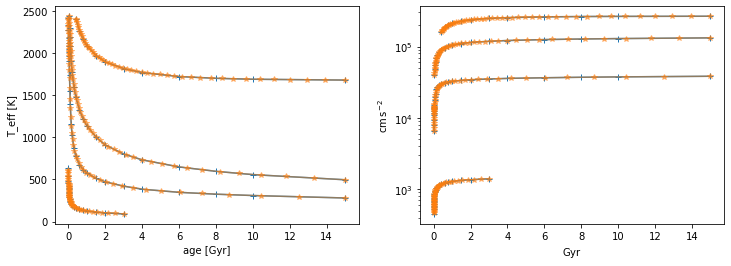

In [3]:
fig, (tax, gax) = plt.subplots(ncols=2, figsize=(12, 4))
for test_mass in tabulated_masses[::20]:
    mask = dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun'] == test_mass.to(u.Msun).value
    subset = dd.BOBCAT_EVOLUTION_TABLES_M0.mass[mask]
    tax.plot(subset['age_Gyr'], subset['T_eff_K'], '+-C0')
    gax.plot(subset['age_Gyr'], 10**subset['log_g_cm_per_s2'] * u.cm/u.s**2, '+-C0')

    interp_ages = np.logspace(np.log10(np.min(subset['age_Gyr'])), np.log10(np.max(subset['age_Gyr']))) * u.Gyr
    if interp_ages[-1] > np.max(subset['age_Gyr']) * u.Gyr:
        interp_ages[-1] = np.max(subset['age_Gyr']) * u.Gyr
    T_evol, T_eff, surface_gravity = dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties(
        test_mass,
        interp_ages,
    )
    tax.plot(interp_ages, T_eff, '*-C1', alpha=0.5)
    gax.plot(interp_ages, surface_gravity, '*-C1', alpha=0.5)

tax.set(
    xlabel='age [Gyr]',
    ylabel='T_eff [K]',
)
_ = gax.set(yscale='log')

# Using $T_\text{eq} \ne T_\text{evol}$

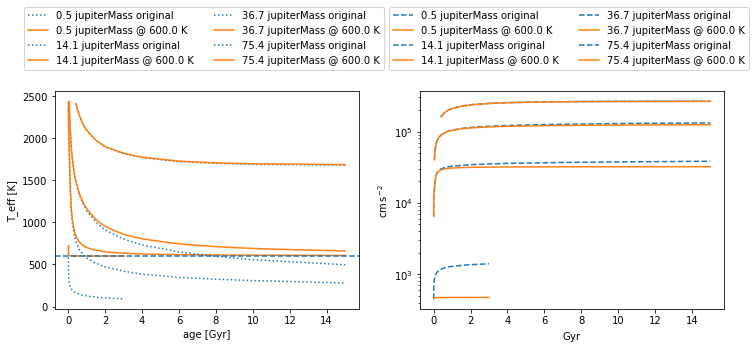

In [4]:
T_eq = 600*u.K
fig, (tax, gax) = plt.subplots(ncols=2, figsize=(12, 4))
for test_mass in tabulated_masses[::20]:
    mask = dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun'] == test_mass.to(u.Msun).value
    subset = dd.BOBCAT_EVOLUTION_TABLES_M0.mass[mask]
    tax.plot(subset['age_Gyr'], subset['T_eff_K'], ls=':', c='C0', label=f"{test_mass.to(u.Mjup):3.1f} original")
    gax.plot(subset['age_Gyr'], 10**subset['log_g_cm_per_s2'] * u.cm/u.s**2, '--C0', label=f"{test_mass.to(u.Mjup):3.1f} original")
    interp_ages = np.logspace(np.log10(np.min(subset['age_Gyr'])), np.log10(np.max(subset['age_Gyr']))) * u.Gyr
    if interp_ages[-1] > np.max(subset['age_Gyr']) * u.Gyr:
        interp_ages[-1] = np.max(subset['age_Gyr']) * u.Gyr
    T_evol, T_eff, surface_gravity = dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties(
        test_mass,
        interp_ages,
        T_eq=T_eq
    )
    tax.plot(interp_ages, T_eff, '-C1', label=f"{test_mass.to(u.Mjup):3.1f} @ {T_eq}")
    gax.plot(interp_ages, surface_gravity, '-C1', label=f"{test_mass.to(u.Mjup):3.1f} @ {T_eq}")

tax.set(
    xlabel='age [Gyr]',
    ylabel='T_eff [K]',
)
gax.set(yscale='log')
tax.axhline(T_eq, ls='--')
tax.legend(loc=(-0.1, 1.1), ncol=2)
gax.legend(loc=(-0.1, 1.1), ncol=2)

# Bobcat synthetic photometry comparison plots

In [5]:
phot_mag_tbl = dd.ref.bobcat.load_bobcat_photometry_mag('photometry_tables/mag_table+0.0')
phot_flux_tbl = dd.ref.bobcat.load_bobcat_photometry_flux('photometry_tables/flux_table+0.0')

In [6]:
phot_masses = np.unique(phot_mag_tbl['mass_Mjup']) * u.Mjup

In [7]:
from tqdm import tqdm

In [8]:
filters = [
    dd.MKO.Lprime.multiply(dd.GEMINI_ATMOSPHERES['Mauna Kea']['mktrans_zm_16_10']),
    dd.MKO.Mprime.multiply(dd.GEMINI_ATMOSPHERES['Mauna Kea']['mktrans_zm_16_10']),
    dd.MKO.H.multiply(dd.GEMINI_ATMOSPHERES['Mauna Kea']['mktrans_zm_16_10']),
]

masses = np.zeros(len(phot_mag_tbl)) * u.Mjup
mags = np.zeros((len(phot_mag_tbl), len(filters)))
for fidx, filter_spec in enumerate(filters):
    print(filter_spec)
    for idx, row in enumerate(tqdm(phot_mag_tbl)):
        T_eff = row['T_eff_K'] * u.K
        g = 10**row['log_g_cm_per_s2'] * u.cm/u.s**2
        mass = row['mass_Mjup'] * u.Mjup
        try:
            spec = dd.BOBCAT_SPECTRA_M0.get(
                temperature=T_eff,
                surface_gravity=g,
                mass=mass,
            )
        except dd.ref.model_grids.BoundsError:
            print(f"OOB: {T_eff=} {g=} {mass=}")
            masses[idx] = np.nan
            mags[idx] = np.nan
            continue
        masses[idx] = mass
        mag = dd.VEGA_BOHLIN_GILLILAND_2004.magnitude(spec, filter_spec)
        mags[idx][fidx] = mag


<Spectrum: (Lprime) * (Gemini ATRAN Mauna Kea airmass 1.0 pwv 1.6 mm) 3e-06 to 4.5e-06 m>


100%|████████████████████████████████████████████████████████████████████| 429/429 [00:23<00:00, 18.30it/s]


<Spectrum: (Mprime) * (Gemini ATRAN Mauna Kea airmass 1.0 pwv 1.6 mm) 4.01e-06 to 5.56e-06 m>


100%|████████████████████████████████████████████████████████████████████| 429/429 [00:21<00:00, 19.84it/s]


<Spectrum: (H) * (Gemini ATRAN Mauna Kea airmass 1.0 pwv 1.6 mm) 1.3e-06 to 2e-06 m>


100%|████████████████████████████████████████████████████████████████████| 429/429 [00:20<00:00, 21.07it/s]


Lprime
{'dtype': dtype('float64'),
 'max': 0.015932545477507887,
 'mean': 0.007691380197856511,
 'median': 0.00786258096833592,
 'min': 0.0019209653581704345,
 'nan': 0,
 'nonfinite': 0,
 'p50': 0.00786258096833592,
 'p90': 0.011328010799910259,
 'p99': 0.014809613358882315,
 'shape': (429,),
 'std': 0.002955791799001485}
Mprime
{'dtype': dtype('float64'),
 'max': 0.00023044471548061551,
 'mean': -0.009191202213622806,
 'median': -0.009905325786855101,
 'min': -0.01622533052322872,
 'nan': 0,
 'nonfinite': 0,
 'p50': -0.009905325786855101,
 'p90': -0.0040389694870661685,
 'p99': -0.0010802270345409784,
 'shape': (429,),
 'std': 0.003578698991761485}
H
{'dtype': dtype('float64'),
 'max': 0.003801823778195157,
 'mean': -0.003287587237727239,
 'median': -0.00315974523697804,
 'min': -0.014998996197139292,
 'nan': 0,
 'nonfinite': 0,
 'p50': -0.00315974523697804,
 'p90': 0.0004773280976280601,
 'p99': 0.002609926526744455,
 'shape': (429,),
 'std': 0.0030704617871561467}


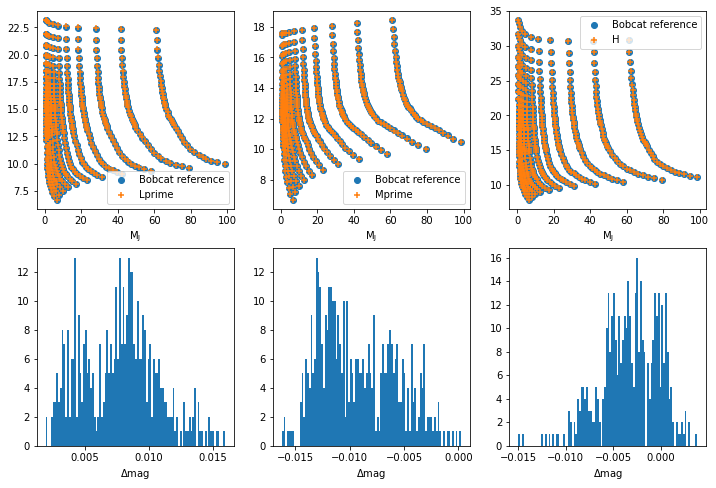

In [9]:
from pprint import pprint
fig, (filtaxes, erraxes) = plt.subplots(nrows=2, ncols=len(filters), figsize=(12, 8))
for idx, (filt, magax) in enumerate(zip(['Lprime', 'Mprime', 'H'], filtaxes.flat)):
    magax.scatter(phot_mag_tbl['mass_Mjup'] * u.Mjup, phot_mag_tbl[f'mag_MKO_{filt}'], label='Bobcat reference')
    print(filt)
    refvals = phot_mag_tbl[f'mag_MKO_{filt}']
    err = mags[:,idx] - refvals
    pprint(dd.describe(err))
    magax.scatter(masses, mags[:,idx], marker='+', label=filt)
    magax.legend()
    erraxes[idx].set(xlabel='$\Delta$mag')
    erraxes[idx].hist(err, bins=100)